In [1]:
import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

random.seed(99)

deconv_size_set = 3 # Number of deconv layer + batchnorm. 2, 3, 4 is tested

In [2]:
# Paths
img_train_dir = f"data/images/train"
img_val_dir   = f"data/images/val"
label_train_dir = f"data/labels/train"
label_val_dir = f"data/labels/val"

images_train = sorted(glob.glob(f"{img_train_dir}/*.jpg", recursive=True))
images_test = sorted(glob.glob(f"{img_val_dir}/*.jpg", recursive = True))
labels_train = sorted(glob.glob(f"{label_train_dir}/*.txt", recursive=True))
labels_test = sorted(glob.glob(f"{label_val_dir}/*.txt", recursive = True))

print("# of training images:",len(images_train))
print("# of training labels:",len(labels_train))
print("# of testing images:",len(images_test))
print("# of testing labels:",len(labels_test))
print("\n")

#Check if there are any mismatched names
train_check, test_check = [], []

for i in range(len(images_train)):
    num1 = images_train[i].split('/')[-1].split('.')[0].split('_')[-1]
    num2 = labels_train[i].split('/')[-1].split('.')[0].split('_')[-1]
    train_check.append(num1 == num2)
if False in train_check:
    print("Stop. There are some mismatched names in training data")
else:
    print("File Name Test: Good to go(1/2)")

for i in range(len(images_test)):
    num1 = images_test[i].split('/')[-1].split('.')[0].split('_')[-1]
    num2 = labels_test[i].split('/')[-1].split('.')[0].split('_')[-1]
    test_check.append(num1 == num2)
if False in test_check:
    print("Stop. There are some mismatched names in training data")
else:
    print("File Name Test: Good to go(2/2)")


# of training images: 18776
# of training labels: 18776
# of testing images: 7992
# of testing labels: 7992


File Name Test: Good to go(1/2)
File Name Test: Good to go(2/2)


In [3]:
#Test set generation
valid_numbers = random.sample(range(int(len(images_test))), int(len(images_test) / 2))
test_numbers = [i for i in range(len(images_test)) if i not in valid_numbers]

images_valid = sorted([images_test[i] for i in valid_numbers])
labels_valid = sorted([labels_test[i] for i in valid_numbers])

images_test = sorted([images_test[i] for i in test_numbers])
labels_test = sorted([labels_test[i] for i in test_numbers])

#Checking
print(images_train[0:5])
print(labels_train[0:5])
print("\n")
print(images_valid[0:5])
print(labels_valid[0:5])
print("\n")
print(images_test[0:5])
print(labels_test[0:5])
        

['data/images/train/IMG_00000001.jpg', 'data/images/train/IMG_00000006.jpg', 'data/images/train/IMG_00000007.jpg', 'data/images/train/IMG_00000008.jpg', 'data/images/train/IMG_00000010.jpg']
['data/labels/train/IMG_00000001.txt', 'data/labels/train/IMG_00000006.txt', 'data/labels/train/IMG_00000007.txt', 'data/labels/train/IMG_00000008.txt', 'data/labels/train/IMG_00000010.txt']


['data/images/val/IMG_00000002.jpg', 'data/images/val/IMG_00000003.jpg', 'data/images/val/IMG_00000004.jpg', 'data/images/val/IMG_00000009.jpg', 'data/images/val/IMG_00000018.jpg']
['data/labels/val/IMG_00000002.txt', 'data/labels/val/IMG_00000003.txt', 'data/labels/val/IMG_00000004.txt', 'data/labels/val/IMG_00000009.txt', 'data/labels/val/IMG_00000018.txt']


['data/images/val/IMG_00000005.jpg', 'data/images/val/IMG_00000017.jpg', 'data/images/val/IMG_00000024.jpg', 'data/images/val/IMG_00000039.jpg', 'data/images/val/IMG_00000046.jpg']
['data/labels/val/IMG_00000005.txt', 'data/labels/val/IMG_00000017.txt'

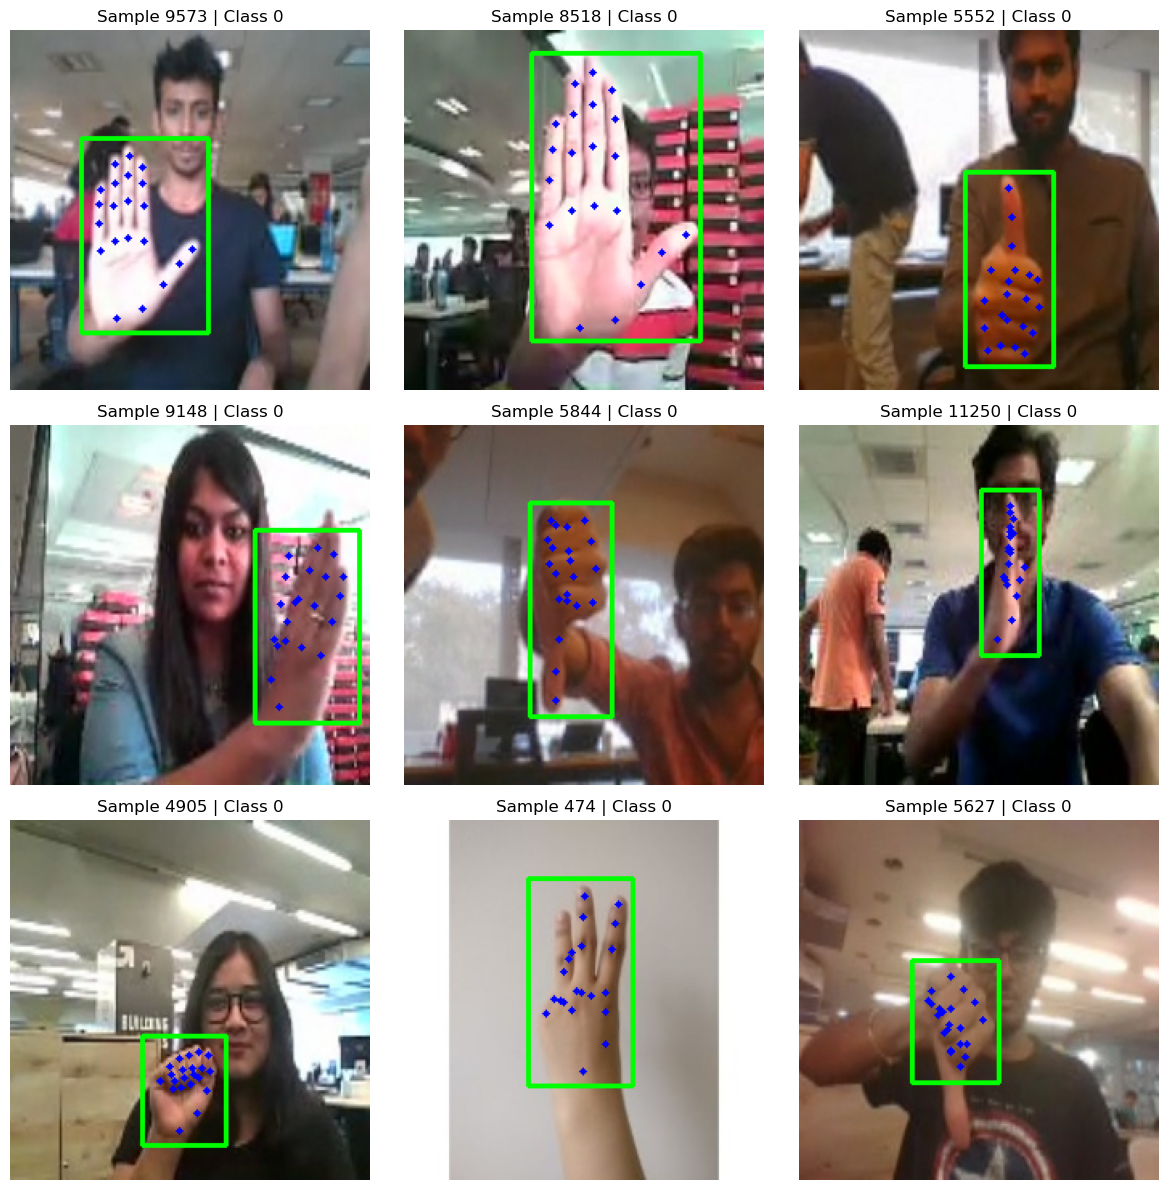

In [4]:
#Visualization for dataset

def draw_bbox(image_bgr, bbox_norm, img_w, img_h, color=(0, 255, 0)):
    cx, cy, bw, bh = bbox_norm
    x = int((cx - bw/2) * img_w)
    y = int((cy - bh/2) * img_h)
    w = int(bw * img_w)
    h = int(bh * img_h)
    out = image_bgr.copy()
    cv2.rectangle(out, (x, y), (x+w, y+h), color, 2)
    return out

def draw_keypoints(image_bgr, keypoints_norm, img_w, img_h, color=(255,0,0)):
    out = image_bgr.copy()
    keypoints = np.array(keypoints_norm).reshape(-1, 3)  # (21,3)

    for (x, y, v) in keypoints:
        if v > 0:
            px, py = int(round(x * img_w)), int(round(y * img_h))
            cv2.circle(out, (px, py), 2, color, -1)
    return out

# 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

# random number
sample_indices = random.sample(range(len(labels_train)), 9)

for idx, sample_num in enumerate(sample_indices):
    with open(labels_train[sample_num], "r", encoding="utf-8") as f:
        text = f.read()

    text_list = list(map(float, text.split()))
    obj_class = int(text_list[0])
    bbox = text_list[1:5]
    key_points = text_list[5:]

    # Ream images
    image = cv2.imread(images_train[sample_num])
    H, W = image.shape[:2]

    vis = draw_bbox(image, bbox, W, H)
    vis = draw_keypoints(vis, key_points, W, H)

    # subplot
    axes[idx].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"Sample {sample_num} | Class {obj_class}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [5]:
#device check / setting
device = "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA available:", torch.cuda.is_available())
print("Device being used:", device)
if device == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current CUDA device index:", torch.cuda.current_device())

CUDA available: True
Device being used: cuda
GPU Name: Orin
Current CUDA device index: 0


In [6]:
###Generate Dataset

def make_heatmaps(coords_hm, Hm, Wm, sigma=2.5):
    """
    coords_hm: (K,2) in heatmap pixel space
    return: (K, Hm, Wm)
    """
    device = coords_hm.device
    ys = torch.arange(Hm, device=device).view(1, Hm, 1).float()
    xs = torch.arange(Wm, device=device).view(1, 1, Wm).float()
    xk = coords_hm[:, 0].view(21, 1, 1)
    yk = coords_hm[:, 1].view(21, 1, 1)
    g = torch.exp(-((xs - xk) ** 2 + (ys - yk) ** 2) / (2 * sigma ** 2))  # (K,Hm,Wm)
    return g

class Dataset_heatmaps(Dataset):
    def __init__(self, images_list, labels_list, out_size=224, deconv_size = 2, return_heatmap = True):
        self.images_list = images_list
        self.labels_list = labels_list
        self.out_size = out_size
        self.tfm = transforms.Compose([
            transforms.Resize((out_size, out_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.deconv_size = deconv_size
        self.return_heatmap = return_heatmap
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = self.images_list[idx]
        label_path = self.labels_list[idx]
        
        img = Image.open(img_path).convert("RGB")
        W0, H0 = img.size
        img = self.tfm(img)  # -> (3, out, out)
        W = H = self.out_size
        
        with open(label_path, "r", encoding="utf-8") as f:
            vals = list(map(float, f.read().split()))
        
        # keypoints: [x_norm, y_norm, v] * K
        kpts = np.array(vals[5:]).reshape(-1, 3)
        kpts_xy = kpts[:, :2] * np.array([W, H], dtype=np.float32)
        
        scale_rate = {2:8, 3:4, 4:2}
        scale = scale_rate[self.deconv_size] #2deconv -> 8, 3deconv -> 4, 4deconv -> 2
        
        Hm = H // scale
        Wm = W // scale
        coords_hm = torch.tensor(kpts_xy / scale, dtype=torch.float32)
        
        heatmap = make_heatmaps(coords_hm, Hm, Wm)
        
        if self.return_heatmap:
            return img, heatmap
        else:
            return img, coords_hm

#DataLoader
train_dataset = Dataset_heatmaps(images_train, labels_train, deconv_size = deconv_size_set)
valid_dataset = Dataset_heatmaps(images_valid, labels_valid, deconv_size = deconv_size_set)
test_dataset = Dataset_heatmaps(images_test, labels_test, deconv_size = deconv_size_set, return_heatmap=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True,
                          drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True,
                          drop_last=True)

torch.backends.cudnn.benchmark = True

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large
from tqdm import tqdm
import math

class Model(nn.Module):
    def __init__(self, deconv_size = deconv_size_set):
        super().__init__()
        #MobileNetV3 backbone
        mnet = mobilenet_v3_large(weights="DEFAULT")
        self.backbone = mnet.features #(B, 960, H/32, W/32)
        
        if deconv_size == 2:
            self.deconv = nn.Sequential(
                nn.ConvTranspose2d(960, 256, 4, 2, 1), # */16
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 256, 4, 2, 1), # */8
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                # nn.ConvTranspose2d(256, 256, 4, 2, 1), # */4
                # nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                # nn.ConvTranspose2d(256, 256, 4, 2, 1), # */2
                # nn.BatchNorm2d(256), nn.ReLU(inplace=True)   
            )
            self.head = nn.Conv2d(256, 21, 1)
            
        if deconv_size == 3:
            self.deconv = nn.Sequential(
                nn.ConvTranspose2d(960, 256, 4, 2, 1), # */16
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 256, 4, 2, 1), # */8
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 256, 4, 2, 1), # */4
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                # nn.ConvTranspose2d(256, 256, 4, 2, 1), # */2
                # nn.BatchNorm2d(256), nn.ReLU(inplace=True)   
            )
            self.head = nn.Conv2d(256, 21, 1)
            
        if deconv_size == 4:
            self.deconv = nn.Sequential(
                nn.ConvTranspose2d(960, 256, 4, 2, 1), # */16
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 256, 4, 2, 1), # */8
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 256, 4, 2, 1), # */4
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 256, 4, 2, 1), # */2
                nn.BatchNorm2d(256), nn.ReLU(inplace=True)   
            )
            self.head = nn.Conv2d(256, 21, 1)
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.deconv(x)
        return self.head(x)


model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pos_weight = torch.tensor([5.0], device = device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #changed from: criterion = nn.MSELoss()
epochs = 1000

#Early Stopping
patience = 7
min_delta = 1e-4
best_val = math.inf



In [8]:
#----------------#
# Training 
#----------------# Uncomment this cell for training

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}") #progress bar
    for i, (imgs, hmaps) in enumerate(pbar, start=1):
        imgs, hmaps = imgs.to(device), hmaps.to(device)

        preds = model(imgs)
        loss = criterion(preds, hmaps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        train_loss += batch_loss

        # tqdm setting
        pbar.set_postfix({"batch_loss": f"{batch_loss:.4f}",
                          "avg_loss": f"{train_loss/i:.4f}"})
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        pbar_val = tqdm(valid_loader, desc=f"[Valid] Epoch {epoch+1}/{epochs}")
        for j, (imgs, hmaps) in enumerate(pbar_val, start=1):
            imgs, hmaps = imgs.to(device), hmaps.to(device)
            preds = model(imgs)
            loss = criterion(preds, hmaps).item()
            val_loss += loss

            # tqdm 진행바에 배치별 loss 표시
            pbar_val.set_postfix({"batch_loss": f"{loss:.4f}",
                                  "avg_loss": f"{val_loss/j:.4f}"})
    
    train_loss_avg = train_loss / len(train_loader)
    val_loss_avg = val_loss / len(valid_loader)
    
    
    print(f"[Summary] Epoch {epoch+1}/{epochs} "
          f"Train {train_loss_avg:.4f} | "
          f"Val {val_loss_avg:.4f}")


    if best_val - val_loss_avg > min_delta:
        best_val = val_loss_avg
        epochs_no_improve = 0
        torch.save({"model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "val_loss": best_val}, f"heatmap_test.pth")
        print(f"Validation improved. Saved checkpoint. Best Val Loss={best_val:.6f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val:.6f}")
        break

[Valid] Epoch 1/1000: 100%|██████████| 124/124 [00:15<00:00,  8.05it/s, batch_loss=0.0644, avg_loss=0.0659]


[Summary] Epoch 1/1000 Train 0.0982 | Val 0.0659
Validation improved. Saved checkpoint. Best Val Loss=0.065898


[Valid] Epoch 2/1000: 100%|██████████| 124/124 [00:14<00:00,  8.38it/s, batch_loss=0.0628, avg_loss=0.0628]


[Summary] Epoch 2/1000 Train 0.0621 | Val 0.0628
Validation improved. Saved checkpoint. Best Val Loss=0.062773


[Train] Epoch 3/1000:   2%|▏         | 9/586 [00:05<05:21,  1.80it/s, batch_loss=0.0625, avg_loss=0.0612]


KeyboardInterrupt: 

In [9]:
#Model Load
model_to_load = f"heatmap_test.pth"

if os.path.exists(model_to_load):
    ckpt = torch.load(model_to_load, map_location=device)
    model.load_state_dict(ckpt["model"])
    print(f"Restored best model from epoch {ckpt['epoch']}")
    print(f"Validation loss: {ckpt['val_loss']}")


Restored best model from epoch 1
Validation loss: 0.06277307128954318


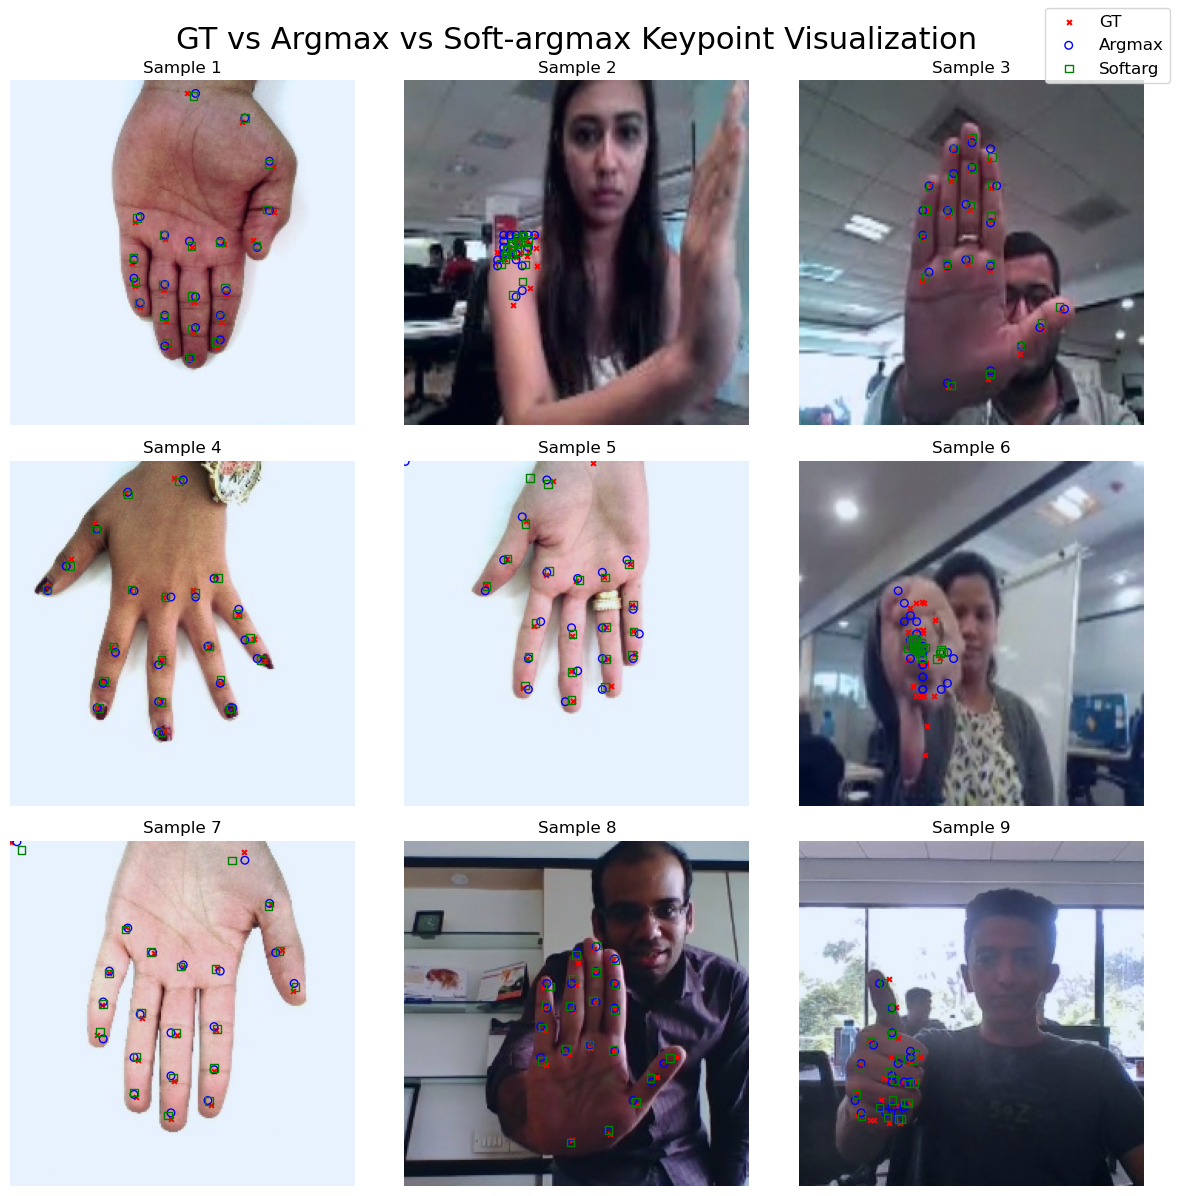

In [10]:
#Softarg version
def heatmap_to_coords_softarg(hmaps, beta=1.0):
    """
    hmaps: (B, K, H, W)  (logits or probs)
    return: list of (K,2) coordinates [(x,y), ...] in heatmap scale (supports sub-pixel precision)
    beta: inverse of softmax temperature (larger values emphasize the peak more)
    """
    B, K, H, W = hmaps.shape
    # Normalize with softmax over (H*W) dimension (works for logits or probs)
    p = torch.softmax(hmaps.view(B, K, -1) * beta, dim=-1).view(B, K, H, W)

    # Coordinate grid (H, W)
    ys = torch.arange(H, device=hmaps.device, dtype=torch.float32).view(1, 1, H, 1)
    xs = torch.arange(W, device=hmaps.device, dtype=torch.float32).view(1, 1, 1, W)

    # Expected value E[x], E[y]
    ex = (p * xs).sum(dim=(2, 3))   # (B, K)
    ey = (p * ys).sum(dim=(2, 3))   # (B, K)

    # Convert to list format
    coords = []
    for b in range(B):
        kp = [(ex[b, k].item(), ey[b, k].item()) for k in range(K)]
        coords.append(kp)
    return coords


#Argmax version
def heatmap_to_coords_argmax(hmaps):
    B, K, H, W = hmaps.shape
    coords = []
    for b in range(B):
        kp = []
        for k in range(K):
            hm = hmaps[b, k]
            idx = hm.argmax()
            y, x = divmod(idx.item(), W)
            kp.append((x, y))
        coords.append(kp)
    return coords

#Evaluation
model.eval()
with torch.no_grad():
    imgs, hmaps = next(iter(test_loader))   
    imgs = imgs.to(device)
    preds = model(imgs)                     
    preds_prob = torch.sigmoid(preds).cpu() 
    gt_hmaps = hmaps      

#heatmap -> coords
pred_coords_soft = heatmap_to_coords_softarg(preds)
pred_coords_arg  = heatmap_to_coords_argmax(preds_prob)
gt_coords        = gt_hmaps

#Rescaling
Hm, Wm = preds.shape[2:]
H,  W  = imgs.shape[2:]
scale_x = W / Wm
scale_y = H / Hm

# Visualization (GT=red, Argmax=blue, Soft-argmax=green)

n_show = min(9, imgs.size(0))  # show up to 9 samples
cols = 3
rows = (n_show + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

# Flag to avoid duplicate labels
labels_used = {"GT": False, "Argmax": False, "Soft-argmax": False}

for i in range(n_show):
    ax = axes[i]
    img = imgs[i].cpu().permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    ax.imshow(img)

    # --- GT (red X) ---
    for (x, y) in gt_coords[i]:
        ax.scatter(x * scale_x, y * scale_y, c="red", s=12, marker="x",
                   label="GT" if not labels_used["GT"] else None)
    labels_used["GT"] = True  # use label only once

    # --- Argmax (blue circle) ---
    for (x, y) in pred_coords_arg[i]:
        ax.scatter(x * scale_x, y * scale_y, edgecolors="blue", facecolors="none",
                   s=30, marker="o",
                   label="Argmax" if not labels_used["Argmax"] else None)
    labels_used["Argmax"] = True

    # --- Soft-argmax (green square) ---
    for (x, y) in pred_coords_soft[i]:
        ax.scatter(x * scale_x, y * scale_y, edgecolors="green", facecolors="none",
                   s=30, marker="s",
                   label="Softarg" if not labels_used["Soft-argmax"] else None)
    labels_used["Soft-argmax"] = True

    ax.set_title(f"Sample {i+1}")
    ax.axis("off")

# Hide empty subplots
for j in range(n_show, len(axes)):
    axes[j].axis("off")

# Add a single figure-level legend (no duplicates)
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
    
# Remove duplicates
unique = dict(zip(labels, handles))

fig.legend(unique.values(), unique.keys(), loc="upper right", fontsize=12)
fig.suptitle("GT vs Argmax vs Soft-argmax Keypoint Visualization", fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:

# def calculate_pck(threshold_px, softarg=True): #pck: Percentage of Correct Keypoints
#     total_correct = 0
#     total_pts = 0
#     with torch.no_grad():
#         for imgs, hmaps in test_loader:
#             imgs = imgs.to(device)
#             preds = model(imgs)  # for softarg
#             preds_prob = torch.sigmoid(preds)  # for argmax
#             B, K, Hm, Wm = preds.shape

#             if softarg:
#                 pred_img = torch.tensor(heatmap_to_coords_softarg(preds), dtype=torch.float32)  # (B,K,2)
#             else:
#                 pred_img = torch.tensor(heatmap_to_coords_argmax(preds_prob), dtype=torch.float32)  # (B,K,2)

#             gt_img = hmaps * 8

#             dists = torch.norm(pred_img - gt_img, dim=2) 
#             total_correct += (dists <= threshold_px).sum().item()
#             total_pts += B * K

#     print(f"PCK@{threshold_px:.2f}px: {total_correct / total_pts:.4f}")
#     return total_correct / total_pts

# # pck cacluation
# thresholds = [0.5, 1, 3, 5, 7]
# print("softarg:")
# pck_results_softarg = [calculate_pck(t) for t in thresholds]
# print("argmax:")
# pck_results_argmax = [calculate_pck(t, softarg = False) for t in thresholds]

# # visualization
# plt.plot(thresholds, pck_results_softarg, marker='o', label = "Softarg")
# plt.plot(thresholds, pck_results_argmax, marker='x', c = 'red', label = "Argmax")
# plt.xlabel("Threshold")
# plt.ylabel("PCK")
# plt.title("PCK vs Threshold (Softarg vs Argamx)")
# plt.legend()
# plt.grid(True)
# plt.show()


In [11]:
import torch
import torch.nn.functional as F

def preds_to_coords_hm(preds, softarg=True, beta=3.0):
    """
    preds: (B,K,Hm,Wm) logits or probs (logits 권장)
    return: coords_hm (B,K,2)  # (x,y) in heatmap pixels
    """
    B, K, Hm, Wm = preds.shape

    if softarg:
        # softmax over spatial dims
        p = F.softmax(preds.view(B, K, -1) * beta, dim=-1).view(B, K, Hm, Wm)  # (B,K,Hm,Wm)
        # coordinate grids
        yy = torch.arange(Hm, device=preds.device, dtype=preds.dtype).view(1,1,Hm,1)
        xx = torch.arange(Wm, device=preds.device, dtype=preds.dtype).view(1,1,1,Wm)
        # expectation
        x = (p * xx).sum(dim=(2,3))
        y = (p * yy).sum(dim=(2,3))
        coords_hm = torch.stack([x, y], dim=-1)  # (B,K,2)
    else:
        # argmax
        idx = preds.view(B, K, -1).argmax(dim=-1)               # (B,K)
        y = (idx // Wm).to(preds.dtype)
        x = (idx %  Wm).to(preds.dtype)
        coords_hm = torch.stack([x, y], dim=-1)  # (B,K,2)

    return coords_hm

def hm_to_img_coords(coords_hm, scale):
    """(B,K,2) heatmap 좌표 -> (B,K,2) 입력이미지(예:224x224) 좌표"""
    return coords_hm * float(scale)

@torch.no_grad()
def calculate_pck(threshold_px, softarg=True, space="hm", scale=8):
    """
    threshold_px: px 단위 임계값
      - space='hm'  -> heatmap 픽셀 기준 임계값
      - space='img' -> 입력 이미지(예:224x224) 픽셀 기준 임계값
    softarg: True면 soft-argmax, False면 argmax
    scale: 입력/heatmap 해상도 비 (예: 224/28=8)
    """
    model.eval()
    total_correct = 0
    total_pts = 0

    for imgs, coords_hm_gt in test_loader:  # GT는 heatmap 좌표계로 옴 (return_heatmap=False)
        imgs = imgs.to(device, non_blocking=True)
        coords_hm_gt = coords_hm_gt.to(device, non_blocking=True)  # (B,K,2), heatmap 좌표

        preds = model(imgs)                         # (B,K,Hm,Wm) logits
        coords_hm_pred = preds_to_coords_hm(preds, softarg=softarg)  # (B,K,2)

        if space == "hm":
            # heatmap 픽셀 기준으로 거리 계산
            dists = torch.linalg.norm(coords_hm_pred - coords_hm_gt, dim=-1)  # (B,K)
            thr = float(threshold_px)
        elif space == "img":
            # 입력 이미지 픽셀 기준으로 비교 (둘 다 scale을 곱해 이미지 좌표계로)
            coords_img_pred = hm_to_img_coords(coords_hm_pred, scale)
            coords_img_gt   = hm_to_img_coords(coords_hm_gt,   scale)
            dists = torch.linalg.norm(coords_img_pred - coords_img_gt, dim=-1)
            thr = float(threshold_px)
        else:
            raise ValueError("space must be 'hm' or 'img'")

        total_correct += (dists <= thr).sum().item()
        total_pts += dists.numel()

    pck = total_correct / total_pts
    unit = "hm-px" if space=="hm" else "img-px"
    print(f"PCK@{threshold_px:.2f} {unit}: {pck:.4f}")
    return pck


# 예: 224px 기준 2~10px
for t in [1, 3, 5, 7, 10]:
    calculate_pck(t, softarg=True, space="img", scale=4)


PCK@1.00 img-px: 0.0827
PCK@3.00 img-px: 0.4529
PCK@5.00 img-px: 0.6876
PCK@7.00 img-px: 0.8009
PCK@10.00 img-px: 0.8832
